In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load COPX Data

In [3]:
copx = yf.Ticker("COPX").history(period="max", interval="1d").reset_index()# yf.Ticker("COPX").history(period="1y", interval="1h")
copx = copx.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
copx['Date'] = pd.to_datetime(copx['Date'].dt.date)
copx = copx.sort_values(by='Date')
copx

,Date,Open,High,Low,Close,Volume
0,2010-04-20,33.153594,33.153594,32.597325,32.664078,1933
1,2010-04-21,32.486071,32.708578,32.063307,32.152309,2900
2,2010-04-22,32.018794,32.018794,31.529278,31.974295,3600
3,2010-04-23,31.863045,32.085552,31.707291,32.085552,1100
4,2010-04-26,33.287095,33.287095,32.041054,32.575069,3600
...,...,...,...,...,...,...
3682,2024-12-04,42.720001,42.919998,42.360001,42.500000,873600
3683,2024-12-05,42.380001,42.900002,42.299999,42.750000,1188400
3684,2024-12-06,42.639999,42.650002,41.889999,41.980000,1012100
3685,2024-12-09,43.509998,44.580002,43.509998,43.560001,2144200


## Feature Engineering

In [5]:

# High and Low as a percentage of Open
copx['High/Open(%)'] = copx['High']/ copx['Open']
copx['Low/Open(%)'] = copx['Low'] / copx['Open']

# Daily return based on Close
copx['Daily Return'] = copx['Close'].pct_change()  

# Date features
copx['Day of Week'] = copx['Date'].dt.day_name()
copx['Month'] = copx['Date'].dt.month
copx['Year'] = copx['Date'].dt.year

# Lag features
LAGS_DAY = [1, 2, 3, 4, 5, 10, 15, 20]
for LAG_DAY in LAGS_DAY:
    copx[f'High/Open(%) [{LAG_DAY} day]'] = copx['High/Open(%)'].shift(LAG_DAY)
    copx[f'Low/Open(%) [{LAG_DAY} day]'] = copx['Low/Open(%)'].shift(LAG_DAY)

# Moving Averages
copx['MA5'] = copx['Close'].shift(1).rolling(window = 5).mean()
copx['MA10'] = copx['Close'].shift(1).rolling(window = 10).mean()
copx['MA20'] = copx['Close'].shift(1).rolling(window = 20).mean()
copx['MA100'] = copx['Close'].shift(1).rolling(window = 100).mean()


copx = copx.dropna().reset_index(drop=True)

starting_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in starting_cols:
    copx[f'Prev{col}'] = copx[col].shift(1)
    
copx

,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,Day of Week,...,Low/Open(%) [20 day],MA5,MA10,MA20,MA100,PrevOpen,PrevHigh,PrevLow,PrevClose,PrevVolume
0,2011-02-02,44.578733,45.137644,44.176316,45.092930,43967,1.012538,0.990973,0.012042,Wednesday,...,0.944660,43.241815,43.286528,43.742598,39.304282,NaN,NaN,NaN,NaN,NaN
1,2011-02-03,45.696550,45.696550,44.779937,45.517700,65400,1.000000,0.979941,0.009420,Thursday,...,0.981142,43.577162,43.306648,43.780604,39.450821,44.578733,45.137644,44.176316,45.092930,43967.0
2,2011-02-04,45.607127,45.920115,45.204710,45.629482,27233,1.006863,0.991176,0.002456,Friday,...,0.991795,44.001933,43.545862,43.865559,39.589593,45.696550,45.696550,44.779937,45.517700,65400.0
3,2011-02-07,45.763618,46.389598,45.763618,45.920113,50667,1.013679,1.000000,0.006369,Monday,...,0.984456,44.690511,43.816376,43.978459,39.728814,45.607127,45.920115,45.204710,45.629482,27233.0
4,2011-02-08,45.830692,46.009545,45.450634,45.830692,51267,1.003902,0.991707,-0.001947,Tuesday,...,0.990516,45.343319,44.089124,44.130482,39.870943,45.763618,46.389598,45.763618,45.920113,50667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,2024-12-04,42.720001,42.919998,42.360001,42.500000,873600,1.004682,0.991573,-0.005615,Wednesday,...,0.997336,42.350001,42.503001,42.793000,43.379400,43.090000,43.349998,42.529999,42.740002,1190100.0
3483,2024-12-05,42.380001,42.900002,42.299999,42.750000,1188400,1.012270,0.998112,0.005882,Thursday,...,0.979540,42.478001,42.463000,42.635500,43.333500,42.720001,42.919998,42.360001,42.500000,873600.0
3484,2024-12-06,42.639999,42.650002,41.889999,41.980000,1012100,1.000235,0.982411,-0.018012,Friday,...,1.000000,42.592001,42.485001,42.580500,43.295200,42.380001,42.900002,42.299999,42.750000,1188400.0
3485,2024-12-09,43.509998,44.580002,43.509998,43.560001,2144200,1.024592,1.000000,0.037637,Monday,...,0.966659,42.462000,42.404000,42.356500,43.263500,42.639999,42.650002,41.889999,41.980000,1012100.0


### Using other ETFs

- First Quantum Minerals Ltd. (FM.TO)
- Lundin Mining Corporation (LUN.TO)
- Capstone Copper Corp. (CS.TO)
- Boliden AB (BOL.ST)
- Ivanhoe Mines Ltd. (IVN.TO)
- Glencore plc (GLEN.L)
- Southern Copper Corporation (SCCO)
- Teck Resources Limited (TECK.B.TO)
- Freeport-McMoRan Inc. (FCX)
- BHP Group Limited (BHP.AX)

In [6]:
tickers = ['FM.TO', 'LUN.TO', 'CS.TO', 'BOL.ST', 'IVN.TO'] 
LAG_DAYS = [1, 2, 3, 4, 5]
for ticker in tickers:
    data =  yf.Ticker(ticker).history(period="max", interval="1d").reset_index()
    data['Date'] = pd.to_datetime(data['Date'].dt.date)
    data = data.sort_values(by='Date')
    for LAG_DAY in LAG_DAYS:
        feature1 = f'{ticker} Daily Return [{LAG_DAY} day]'
        feature2 = f'{ticker} High/Open(%) [{LAG_DAY} day]'
        data[feature1] = data['Close'].pct_change().shift(LAG_DAY)
        data[feature2] = (data['High'] / data['Open']).shift(LAG_DAY)
        
        features = data[['Date', feature1, feature2]]
        copx = pd.merge(copx, features, on='Date', how='left')
        
copx

,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,Day of Week,...,IVN.TO Daily Return [1 day],IVN.TO High/Open(%) [1 day],IVN.TO Daily Return [2 day],IVN.TO High/Open(%) [2 day],IVN.TO Daily Return [3 day],IVN.TO High/Open(%) [3 day],IVN.TO Daily Return [4 day],IVN.TO High/Open(%) [4 day],IVN.TO Daily Return [5 day],IVN.TO High/Open(%) [5 day]
0,2011-02-02,44.578733,45.137644,44.176316,45.092930,43967,1.012538,0.990973,0.012042,Wednesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-02-03,45.696550,45.696550,44.779937,45.517700,65400,1.000000,0.979941,0.009420,Thursday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-02-04,45.607127,45.920115,45.204710,45.629482,27233,1.006863,0.991176,0.002456,Friday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-02-07,45.763618,46.389598,45.763618,45.920113,50667,1.013679,1.000000,0.006369,Monday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-02-08,45.830692,46.009545,45.450634,45.830692,51267,1.003902,0.991707,-0.001947,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,2024-12-04,42.720001,42.919998,42.360001,42.500000,873600,1.004682,0.991573,-0.005615,Wednesday,...,0.044896,1.019231,-0.007427,1.002110,0.011809,1.020845,-0.005339,1.001607,0.001604,1.020256
3483,2024-12-05,42.380001,42.900002,42.299999,42.750000,1188400,1.012270,0.998112,0.005882,Thursday,...,-0.014834,1.014322,0.044896,1.019231,-0.007427,1.002110,0.011809,1.020845,-0.005339,1.001607
3484,2024-12-06,42.639999,42.650002,41.889999,41.980000,1012100,1.000235,0.982411,-0.018012,Friday,...,0.014019,1.027055,-0.014834,1.014322,0.044896,1.019231,-0.007427,1.002110,0.011809,1.020845
3485,2024-12-09,43.509998,44.580002,43.509998,43.560001,2144200,1.024592,1.000000,0.037637,Monday,...,-0.003584,1.012308,0.014019,1.027055,-0.014834,1.014322,0.044896,1.019231,-0.007427,1.002110


# Model

Predict High/Open(%)

Train: 70%, Test: 30%

Features: ['Day of Week',
 'Month',
 'Year',
 'High/Open(%) [1 day]',
 'Low/Open(%) [1 day]',
 'High/Open(%) [2 day]',
 'Low/Open(%) [2 day]',
 'High/Open(%) [3 day]',
 'Low/Open(%) [3 day]',
 'High/Open(%) [4 day]',
 'Low/Open(%) [4 day]',
 'High/Open(%) [5 day]',
 'Low/Open(%) [5 day]',
 'High/Open(%) [10 day]',
 'Low/Open(%) [10 day]',
 'High/Open(%) [15 day]',
 'Low/Open(%) [15 day]',
 'High/Open(%) [20 day]',
 'Low/Open(%) [20 day]',
 'MA5',
 'MA10',
 'MA20',
 'MA100',
 'PrevOpen',
 'PrevHigh',
 'PrevLow',
 'PrevClose',
 'PrevVolume',
 'FM.TO Daily Return [1 day]',
 'FM.TO High/Open(%) [1 day]',
 'FM.TO Daily Return [2 day]',
 'FM.TO High/Open(%) [2 day]',
 'FM.TO Daily Return [3 day]',
 'FM.TO High/Open(%) [3 day]',
 'FM.TO Daily Return [4 day]',
 'FM.TO High/Open(%) [4 day]',
 'FM.TO Daily Return [5 day]',
 'FM.TO High/Open(%) [5 day]',
 'LUN.TO Daily Return [1 day]',
 'LUN.TO High/Open(%) [1 day]',
 'LUN.TO Daily Return [2 day]',
 'LUN.TO High/Open(%) [2 day]',
 'LUN.TO Daily Return [3 day]',
 'LUN.TO High/Open(%) [3 day]',
 'LUN.TO Daily Return [4 day]',
 'LUN.TO High/Open(%) [4 day]',
 'LUN.TO Daily Return [5 day]',
 'LUN.TO High/Open(%) [5 day]',
 'CS.TO Daily Return [1 day]',
 'CS.TO High/Open(%) [1 day]',
 'CS.TO Daily Return [2 day]',
 'CS.TO High/Open(%) [2 day]',
 'CS.TO Daily Return [3 day]',
 'CS.TO High/Open(%) [3 day]',
 'CS.TO Daily Return [4 day]',
 'CS.TO High/Open(%) [4 day]',
 'CS.TO Daily Return [5 day]',
 'CS.TO High/Open(%) [5 day]',
 'BOL.ST Daily Return [1 day]',
 'BOL.ST High/Open(%) [1 day]',
 'BOL.ST Daily Return [2 day]',
 'BOL.ST High/Open(%) [2 day]',
 'BOL.ST Daily Return [3 day]',
 'BOL.ST High/Open(%) [3 day]',
 'BOL.ST Daily Return [4 day]',
 'BOL.ST High/Open(%) [4 day]',
 'BOL.ST Daily Return [5 day]',
 'BOL.ST High/Open(%) [5 day]',
 'IVN.TO Daily Return [1 day]',
 'IVN.TO High/Open(%) [1 day]',
 'IVN.TO Daily Return [2 day]',
 'IVN.TO High/Open(%) [2 day]',
 'IVN.TO Daily Return [3 day]',
 'IVN.TO High/Open(%) [3 day]',
 'IVN.TO Daily Return [4 day]',
 'IVN.TO High/Open(%) [4 day]',
 'IVN.TO Daily Return [5 day]',
 'IVN.TO High/Open(%) [5 day]']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# We want to predict `High/Open(%)` 
target = 'High/Open(%)'
cols_to_ignore = [target, 'Date', 'index', 'Low/Open(%)', 'Daily Return'] + starting_cols
features = [col for col in copx.columns if col not in cols_to_ignore]

# Drop all rows with missing values 
copx = copx.dropna() 

# Identify categorical and numerical columns
categorical_cols = copx.select_dtypes(include=['object', 'category']).columns
numerical_cols = [col for col in features if col not in categorical_cols]

# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Apply one-hot encoding transformation
X = copx[features]
X_transformed = preprocessor.fit_transform(X)

# Convert back to DataFrame
encoded_features = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(input_features=categorical_cols)
)

feature_names = list(encoded_features) + numerical_cols
X_encoded = pd.DataFrame(X_transformed, columns=feature_names, index=X.index)

y = copx[target]

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, shuffle=False, random_state=42)

## Baseline

In [8]:
copx_test = copx.iloc[len(X_train):].reset_index(drop=True)
copx_test 

,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,Day of Week,...,IVN.TO Daily Return [1 day],IVN.TO High/Open(%) [1 day],IVN.TO Daily Return [2 day],IVN.TO High/Open(%) [2 day],IVN.TO Daily Return [3 day],IVN.TO High/Open(%) [3 day],IVN.TO Daily Return [4 day],IVN.TO High/Open(%) [4 day],IVN.TO Daily Return [5 day],IVN.TO High/Open(%) [5 day]
0,2021-04-26,37.046303,37.704866,36.916447,37.667763,1186800,1.017777,0.996495,0.035441,Monday,...,0.028369,1.019930,-0.018561,1.005834,0.024970,1.027381,-0.012911,1.022459,-0.004673,1.002331
1,2021-04-27,37.797618,37.881097,37.408049,37.575005,669100,1.002209,0.989693,-0.002463,Tuesday,...,0.031035,1.027460,0.028369,1.019930,-0.018561,1.005834,0.024970,1.027381,-0.012911,1.022459
2,2021-04-28,37.445149,37.843995,37.120508,37.695587,426300,1.010651,0.991330,0.003209,Wednesday,...,-0.007804,1.016593,0.031035,1.027460,0.028369,1.019930,-0.018561,1.005834,0.024970,1.027381
3,2021-04-29,38.298494,38.734439,37.129780,37.630657,632300,1.011383,0.969484,-0.001722,Thursday,...,0.005618,1.008989,-0.007804,1.016593,0.031035,1.027460,0.028369,1.019930,-0.018561,1.005834
4,2021-04-30,37.454429,37.556460,36.508328,36.601082,792700,1.002724,0.974740,-0.027360,Friday,...,-0.013408,1.007760,0.005618,1.008989,-0.007804,1.016593,0.031035,1.027460,0.028369,1.019930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,2024-12-04,42.720001,42.919998,42.360001,42.500000,873600,1.004682,0.991573,-0.005615,Wednesday,...,0.044896,1.019231,-0.007427,1.002110,0.011809,1.020845,-0.005339,1.001607,0.001604,1.020256
870,2024-12-05,42.380001,42.900002,42.299999,42.750000,1188400,1.012270,0.998112,0.005882,Thursday,...,-0.014834,1.014322,0.044896,1.019231,-0.007427,1.002110,0.011809,1.020845,-0.005339,1.001607
871,2024-12-06,42.639999,42.650002,41.889999,41.980000,1012100,1.000235,0.982411,-0.018012,Friday,...,0.014019,1.027055,-0.014834,1.014322,0.044896,1.019231,-0.007427,1.002110,0.011809,1.020845
872,2024-12-09,43.509998,44.580002,43.509998,43.560001,2144200,1.024592,1.000000,0.037637,Monday,...,-0.003584,1.012308,0.014019,1.027055,-0.014834,1.014322,0.044896,1.019231,-0.007427,1.002110


### Baseline - buy and hold

Buy at the very first open, sell at the most recent close.

If we buy on the first day Open and sell at the last day Close, we would have 116.5% of what we started with.


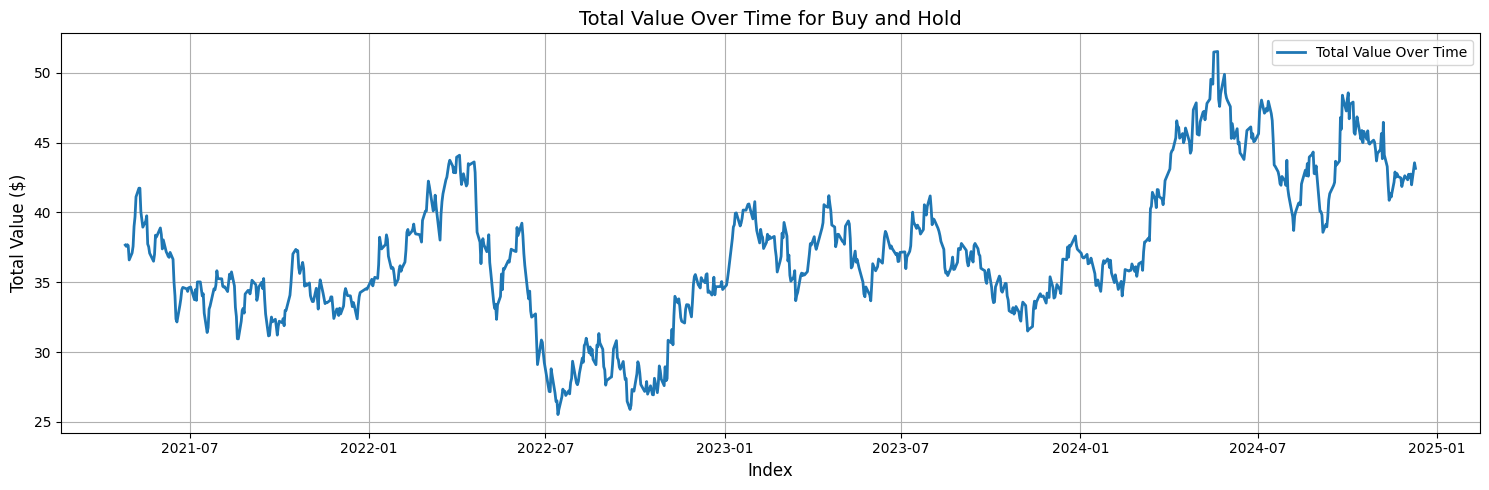

In [9]:
principal = 100 # Starting dollars

buy_price = copx_test['Open'].iloc[0] # start on the same date as the test set
sell_price = copx_test['Close'].iloc[-1] # most recent date

total_value = principal / buy_price * sell_price
profit_and_loss_percentage = total_value / principal
profit_and_loss_percentage_formatted = f'{round(profit_and_loss_percentage, 4) * 100}%'

print(f'If we buy on the first day Open and sell at the last day Close, we would have {profit_and_loss_percentage_formatted} of what we started with.')

plt.figure(figsize=(15, 5))
plt.plot(copx_test['Date'].values, copx_test['Close'].values, label='Total Value Over Time', linewidth=2)

plt.title('Total Value Over Time for Buy and Hold', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Total Value ($)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Baseline - buy everyday, simple take profit threshold

If we buy everyday with a simple take profit threshold of 1.03, we would have 50.07% of what we started with.


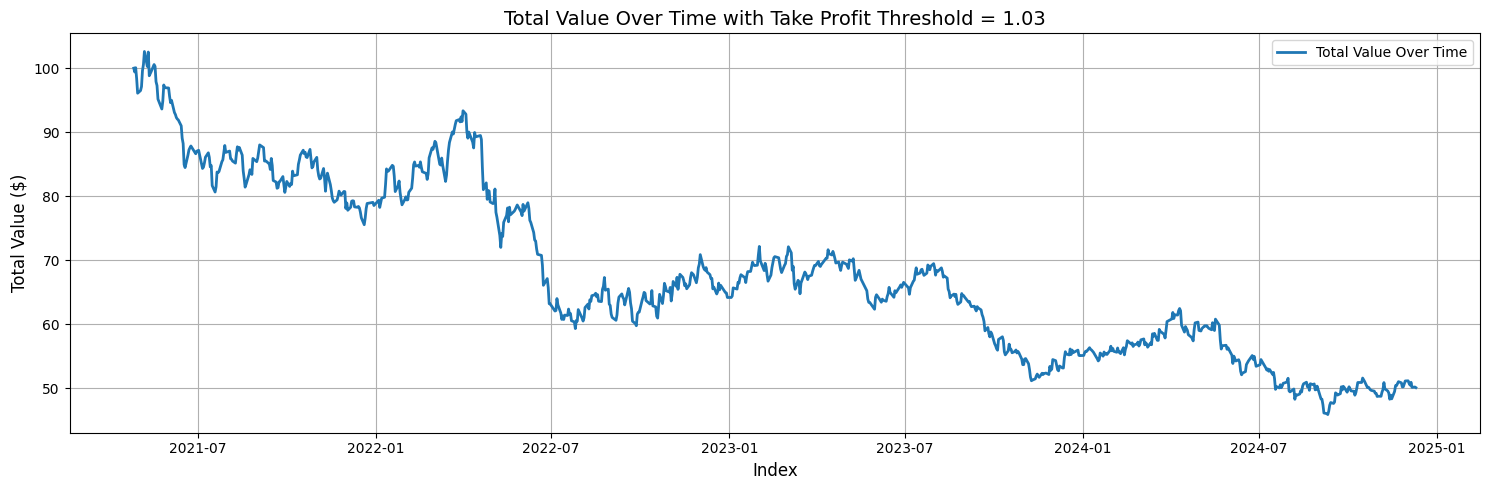

In [11]:
principal = 100 # Starting dollars
take_profit_threshold = 1.03 # Can change

# No stop loss, only take profit
def get_profit_loss(row):
    take_profit = row['Open'] * take_profit_threshold
    if row['High'] >= take_profit:
        return take_profit
    
    return row['Close']

copx_test['Value Sold Per Stock'] = copx_test.apply(get_profit_loss, axis=1)

copx_test['Total Value'] = None
for i in range(len(copx_test)):
    if i == 0:
        # The first row's Stock Value is the principal
        copx_test.loc[i, 'Total Value'] = principal
    else:
        # Calculate current row's Stock Value
        n_stocks = copx_test.loc[i - 1, 'Total Value'] / copx_test.loc[i, 'Open']
        copx_test.loc[i, 'Total Value'] = (
            n_stocks * copx_test.loc[i, 'Value Sold Per Stock']
        )

profit_and_loss_percentage = copx_test.iloc[-1]['Total Value'] / principal
profit_and_loss_percentage_formatted = f'{round(profit_and_loss_percentage, 4) * 100}%'

print(f'If we buy everyday with a simple take profit threshold of {take_profit_threshold}, we would have {profit_and_loss_percentage_formatted} of what we started with.')

plt.figure(figsize=(15, 5))
plt.plot(copx_test['Date'].values, copx_test['Total Value'].values, label='Total Value Over Time', linewidth=2)

plt.title(f'Total Value Over Time with Take Profit Threshold = {take_profit_threshold}', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Total Value ($)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Why is the baseline performing so poorly?

In [227]:
np.mean((copx_test['Close'] - copx_test['Open']) > 0) # Close is higher than Open on less than half of the days 

0.4645308924485126

In [228]:
np.mean((copx_test['High/Open(%)']) > take_profit_threshold) # Successfully take profit on very few days, suffering big losses on the other days

0.029748283752860413

The baseline performing so poorly because COPX generally closes lower than open.

### Model Metric Evaluation

In [12]:
# Metric evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_train_and_test_result(y_train, y_pred_train, y_test, y_pred_test):
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    print(f"Train MSE: {train_mse:.6f}")
    print(f"Test MSE: {test_mse:.6f}")

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"Train R²: {train_r2:.6f}")
    print(f"Test R²: {test_r2:.6f}")

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print(f"Train MAE: {train_mae:.6f}")
    print(f"Test MAE: {test_mae:.6f}")

    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

    print(f"Train MAPE: {train_mape:.2f}%")
    print(f"Test MAPE: {test_mape:.2f}%")

### Random Forest Regression (Ester)

Train MSE: 0.000013
Test MSE: 0.000084
Train R²: 0.868993
Test R²: -0.032681
Train MAE: 0.002683
Test MAE: 0.007185
Train MAPE: 0.26%
Test MAPE: 0.71%


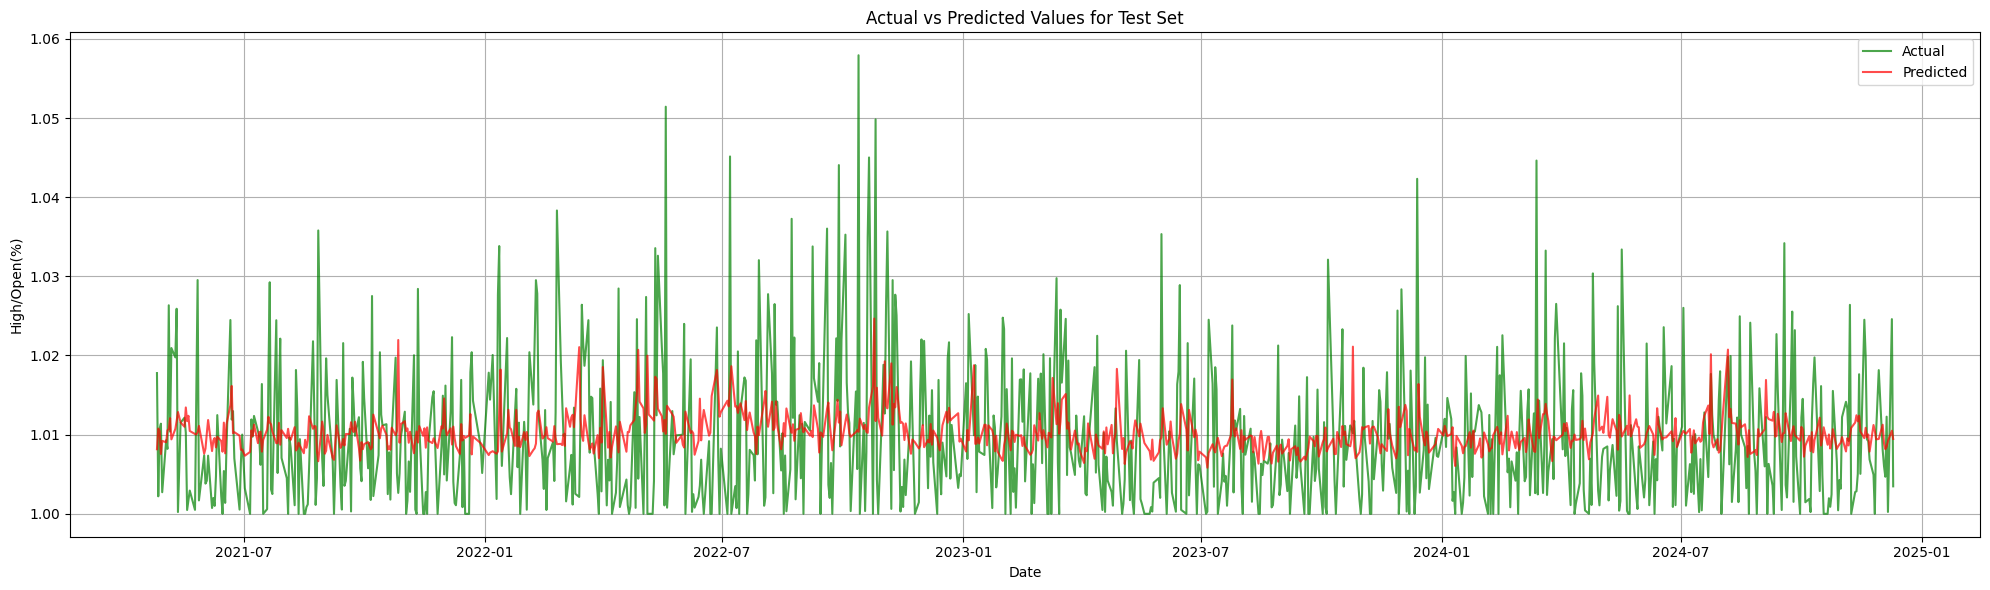

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

evaluate_train_and_test_result(y_train, y_pred_train, y_test, y_pred_test)

# Plot actual vs. predicted
test_dates = np.array(copx['Date'].iloc[len(y_train):])
actual_result = np.array(y_test)

plt.figure(figsize=(20, 6))

# Plot actual
plt.plot(test_dates, actual_result, label="Actual", c='green', alpha=0.7)

# Plot predicted
plt.plot(test_dates, y_pred_test, label="Predicted", c='red', alpha=0.7)

plt.title("Actual vs Predicted Values for Test Set")
plt.xlabel("Date")
plt.ylabel("High/Open(%)")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Stopped loss on 2022-05-05
If we use Random Forest Regression, we would have 90.51% of what we started with.


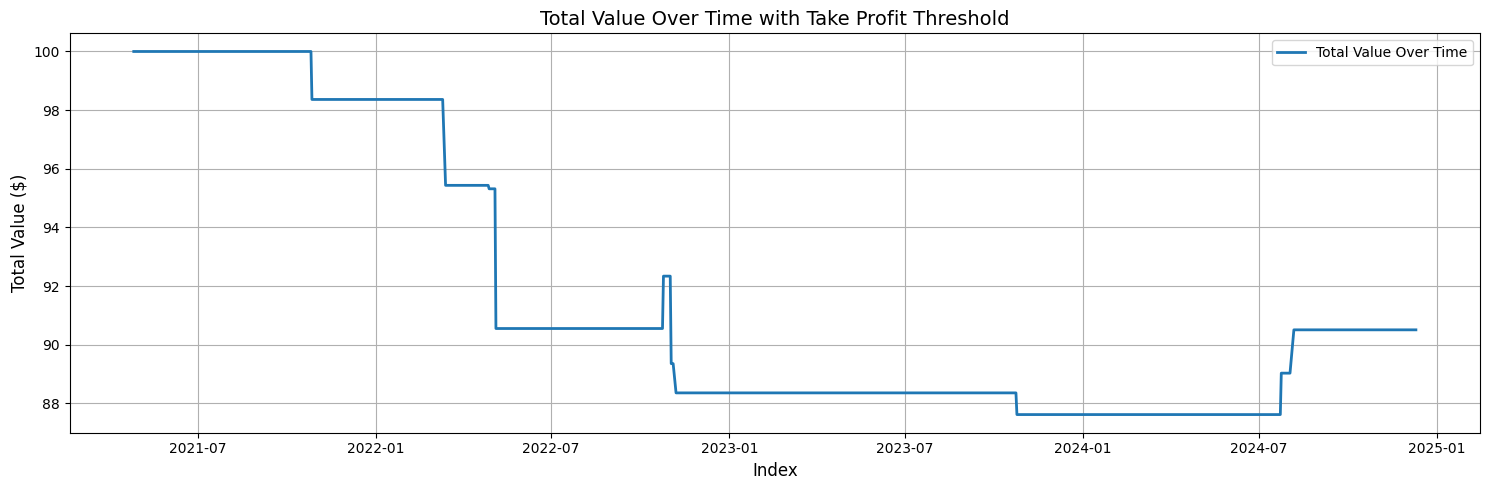

In [14]:
def model_result_and_plot(y_pred_test, model_name='Random Forest Regression', principal=100, stop_loss_threshold=0.95, buy_threshold=1.01):
    copx_test = copx.iloc[len(X_train):].reset_index(drop=True)
    copx_test['Prediction'] = y_pred_test

    # take profit depends on model prediction, stop loss is default 0.95 
    def get_profit_loss(row):
        take_profit_threshold = (1 + (row['Prediction'] - 1) * 0.8) # playing around with different scales of the predicted take profit threshold
        take_profit = row['Open'] * take_profit_threshold 
        stop_loss = row['Open'] * stop_loss_threshold
        # buy if prediction of High/Open(%) is higher than buy_threshold
        if row['Prediction'] >= buy_threshold:
            if row['High'] >= take_profit:
                return take_profit
            elif row['Low'] < stop_loss:
                print(f'Stopped loss on {row["Date"].date()}')
                return stop_loss
            else:
                return row['Close']
        # not buy
        else:
            return row['Open']

    copx_test['Value Sold Per Stock'] = copx_test.apply(get_profit_loss, axis=1)

    copx_test['Total Value'] = None
    for i in range(len(copx_test)):
        if i == 0:
            # The first row's Stock Value is the principal
            copx_test.loc[i, 'Total Value'] = principal
        else:
            # Calculate current row's Stock Value
            n_stocks = copx_test.loc[i - 1, 'Total Value'] / copx_test.loc[i, 'Open']
            copx_test.loc[i, 'Total Value'] = (
                n_stocks * copx_test.loc[i, 'Value Sold Per Stock']
            )

    profit_and_loss_percentage = copx_test.iloc[-1]['Total Value'] / principal
    profit_and_loss_percentage_formatted = f'{round(profit_and_loss_percentage, 4) * 100}%'

    print(f'If we use {model_name}, we would have {profit_and_loss_percentage_formatted} of what we started with.')

    plt.figure(figsize=(15, 5))
    plt.plot(copx_test['Date'].values, copx_test['Total Value'].values, label='Total Value Over Time', linewidth=2)

    plt.title('Total Value Over Time with Take Profit Threshold', fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Total Value ($)', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show() 
    
    return copx_test
    
result_df = model_result_and_plot(y_pred_test, model_name='Random Forest Regression', buy_threshold=1.019)

## KNN (Renee)
not a very good predictive model in this case

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

# We want to predict `High/Open(%)` 
target = 'High/Open(%)'
cols_to_ignore = [target, 'Date', 'index', 'Low/Open(%)', 'Daily Return'] + starting_cols
featuresknn = [col for col in copx.columns if col not in cols_to_ignore]

# Drop all rows with missing values 
copx = copx.dropna() 

# Identify categorical and numerical columns
categorical_cols = copx.select_dtypes(include=['object', 'category']).columns
numerical_cols = [col for col in featuresknn if col not in categorical_cols]

# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', MinMaxScaler(), numerical_cols)
    ]
)

# Apply one-hot encoding transformation
X = copx[featuresknn]
X_transformed = preprocessor.fit_transform(X)

# Convert back to DataFrame
encoded_features = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(input_features=categorical_cols)
)

feature_names = list(encoded_features) + numerical_cols
X_encoded = pd.DataFrame(X_transformed, columns=feature_names, index=X.index)

y = copx[target]

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, shuffle = False, random_state = 42)

knn = KNeighborsRegressor(n_neighbors = 5)
knn.fit(X_train,y_train)

y_predknntest = knn.predict(X_test)
y_predknntrain = knn.predict(X_train)

evaluate_train_and_test_result(y_train, y_predknntrain, y_test, y_predknntest)

Train MSE: 0.000069
Test MSE: 0.000089
Train R²: 0.324059
Test R²: -0.091483
Train MAE: 0.005856
Test MAE: 0.007254
Train MAPE: 0.58%
Test MAPE: 0.72%


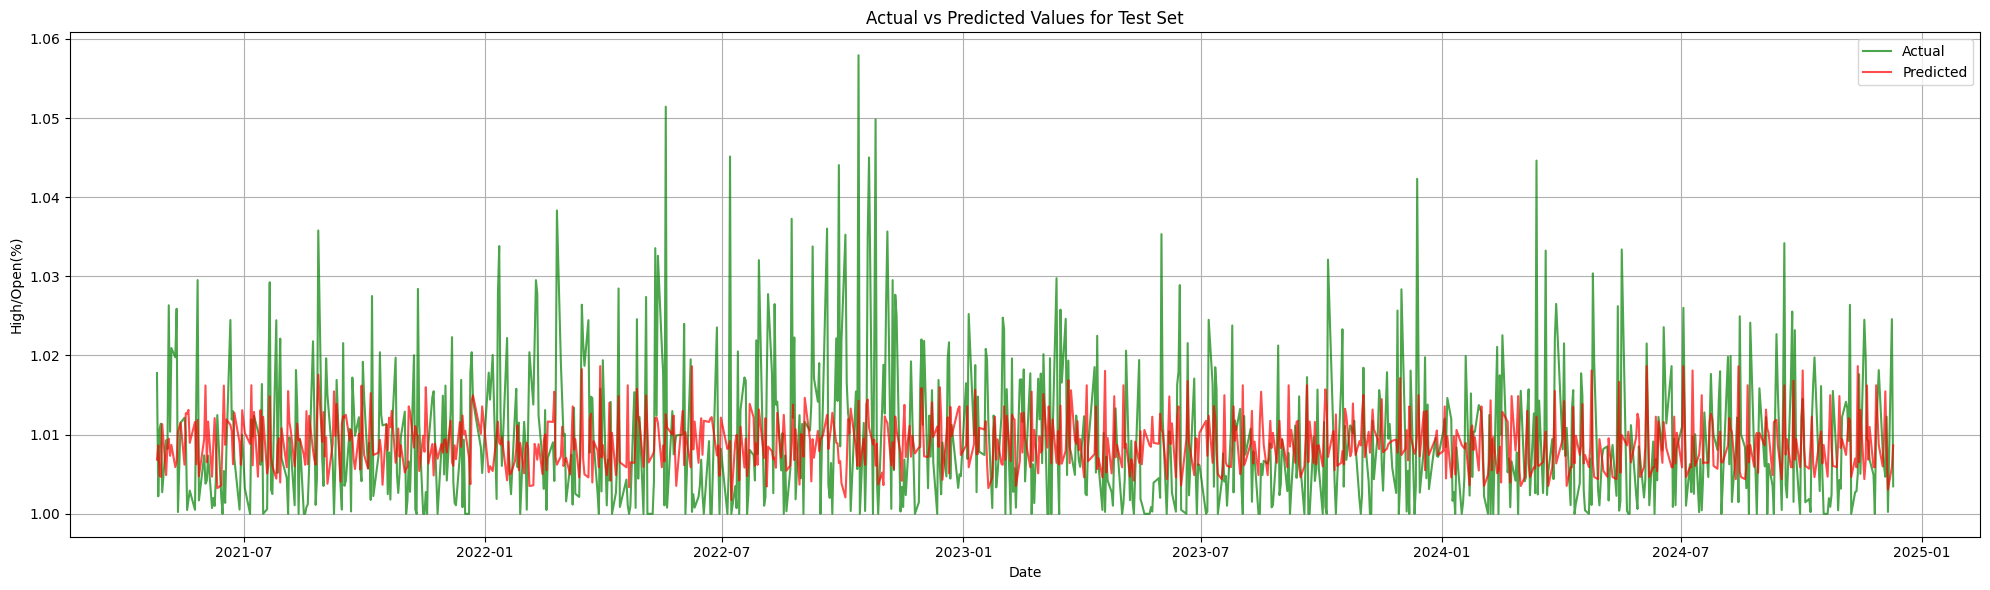

In [16]:
import matplotlib.pyplot as plt

test_dates = np.array(copx['Date'].iloc[len(y_train):])
actual_result = np.array(y_test)

plt.figure(figsize=(20, 6))

# Plot actual
plt.plot(test_dates, actual_result, label="Actual", c='green', alpha=0.7)

# Plot predicted
plt.plot(test_dates, y_predknntest, label="Predicted", c='red', alpha=0.7)

plt.title("Actual vs Predicted Values for Test Set")
plt.xlabel("Date")
plt.ylabel("High/Open(%)")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Stopped loss on 2022-05-05
Stopped loss on 2022-06-23
If we use KNN, we would have 63.79% of what we started with.


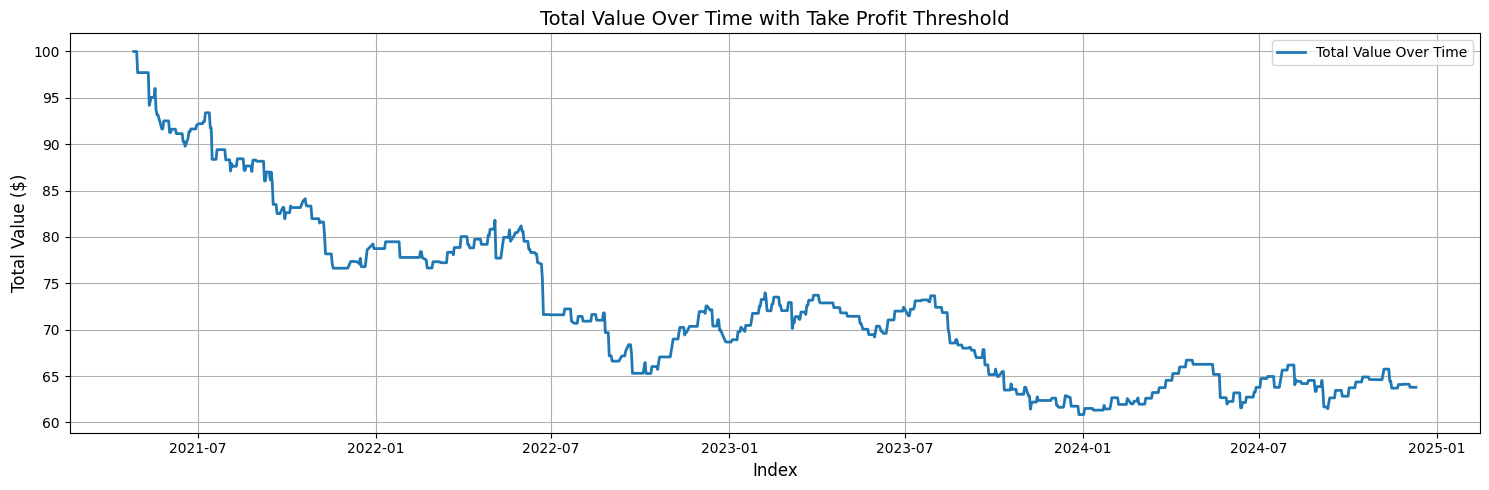

In [19]:
result_df = model_result_and_plot(y_predknntest, model_name='KNN', buy_threshold=1.01)

## EDA

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

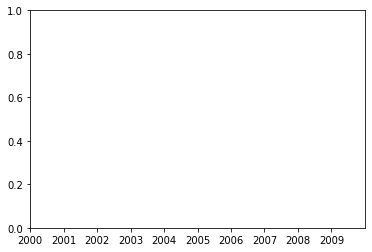

In [13]:
sns.lineplot(data=copx, x="Date", y="Close")
plt.show()

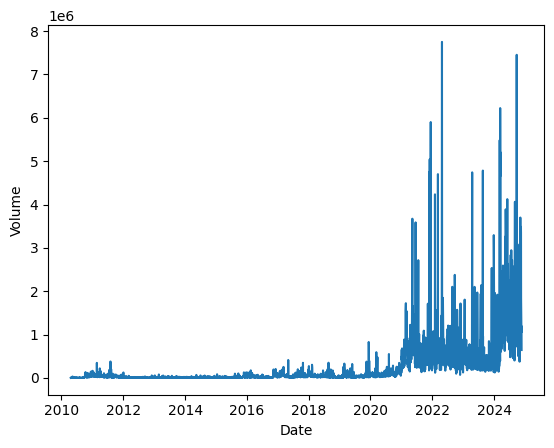

In [ ]:
sns.lineplot(data=copx, x="Date", y="Volume")
plt.show()

In [ ]:
# train_dates = np.array(copx['Date'].iloc[:len(y_train)])
# test_dates = np.array(copx['Date'].iloc[len(y_train):])
# full_dates = np.array(copx['Date'])
# actual_result = np.array(copx['High/Open(%)'])

# plt.figure(figsize=(12, 6))

# # Plot actual
# plt.plot(full_dates, actual_result, label="Actual", c='green', alpha=0.7)

# # Plot predicted
# plt.plot(train_dates, y_pred_train, label="Predicted (Train)", c='blue', alpha=0.7)
# plt.plot(test_dates, y_pred_test, label="Predicted (Test)", c='red', alpha=0.7)

# plt.title("Actual vs Predicted Values for Train and Test Sets")
# plt.xlabel("Date")
# plt.ylabel("High/Open(%)")

# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()